In [7]:
import sys
from typing import List
from datetime import datetime, timedelta
import pytz
from kiteconnect import KiteConnect
import pandas as pd
import os

sys.path.append(os.path.abspath(".."))
# sys.path.append(os.path.abspath(".."))
from backtest import BacktestEngine
from Bardata import BarData

In [3]:
class SSO_strategy(BacktestEngine):
    def __init__(self, config):
        super().__init__(config)
        self.buy = True
        self.closepx = {}
        self.ticks = {}
        self.today = datetime.strptime(config['start_date'], '%Y-%m-%d').date()
        self.start_time = pytz.timezone('Asia/Kolkata').localize(datetime.combine(self.today, datetime.min.time()).replace(hour=9, minute=25, second=0))
        self.end_time = pytz.timezone('Asia/Kolkata').localize(datetime.combine(self.today, datetime.min.time()).replace(hour=10, minute=30, second=0))
        self.executed = {t: False for t in self.trading_symbols.keys()}
        self.high_925 = {}
        self.low_925 = {}
        self.top_gainers = config.get("top_gainers", [])
        self.top_losers = config.get("top_losers", [])

        self.active_orders = {}
        self.option_data = {}
        print(self.trading_symbols)

    def update_bars(self, new_bars: List[BarData]):
        # print(f"Updating {new_bars[0].date} bars")
        for b in new_bars:
            # print(f"Updating bar: {b.date} for instrument {self.trading_symbols[b.instrument_token]}")
            if b.instrument_token not in self.ticks:
                self.ticks[b.instrument_token] = []
            self.ticks[b.instrument_token].append(b)
            if b.instrument_token not in self.closepx:
                self.closepx[b.instrument_token] = []
            self.closepx[b.instrument_token].append(b.close)
            # print(f"Close price for {self.trading_symbols[b.instrument_token]} at {b.date} is {b.close}")
            if b.date > self.start_time and b.instrument_token not in self.high_925:
                print(f"Setting high_925 and low_925 for {self.trading_symbols[b.instrument_token]} at {b.date}")
                self.high_925[b.instrument_token] = max([t.high for t in self.ticks[b.instrument_token][-10:]])
                self.low_925[b.instrument_token] = min([t.low for t in self.ticks[b.instrument_token][-10:]])
            # print("checking all conditions")
            self.check_all_conditions(b)

    def get_option(self,instrument_token,underlying_price,option_type):
        instr_df = pd.DataFrame(self.kite.instruments('NFO'))
        
        instr_tokens = instr_df[instr_df['name'] == self.trading_symbols[instrument_token]]
        expiries = sorted(instr_tokens['expiry'].unique())
        print(f"Available expiries for {self.trading_symbols[instrument_token]}: {expiries}")
        current_month_options = instr_tokens[
            (instr_df['expiry'] == expiries[0]) & 
            (instr_df['instrument_type'].isin(['CE', 'PE']))]
        
        if option_type == 'CE':
            ce_strike = current_month_options[
                            (current_month_options['strike'] >= underlying_price) & 
                            (current_month_options['instrument_type'] == 'CE')
                        ]['strike'].nsmallest(3).nlargest(1)
            ce_tokens = current_month_options[
                            (current_month_options['strike'].isin(ce_strike.values)) & 
                            (current_month_options['instrument_type'] == 'CE')
                        ]['instrument_token'].tolist()
            return ce_tokens[0] if ce_tokens else None
        
        elif option_type == 'PE':
            pe_strike = current_month_options[
                            (current_month_options['strike'] <= underlying_price) & 
                            (current_month_options['instrument_type'] == 'PE')
                        ]['strike'].nlargest(3).nsmallest(1)
            pe_tokens = current_month_options[
                            (current_month_options['strike'].isin(pe_strike.values)) & 
                            (current_month_options['instrument_type'] == 'PE')
                        ]['instrument_token'].tolist()
            return pe_tokens[0] if pe_tokens else None

        return
    
    def check_entry_conditions(self,tick: BarData):
        print(f"Checking entry conditions for {self.trading_symbols[tick.instrument_token]} at {tick.close} on {tick.date}")
        print(f"Current high_925: {self.high_925.get(tick.instrument_token, 0)}")
        print(f"Current low_925: {self.low_925.get(tick.instrument_token, 0)}")
        if tick.close > self.high_925.get(tick.instrument_token, 0) and tick.instrument_token in self.top_gainers:
            print(f"Buy signal for {self.trading_symbols[tick.instrument_token]} at {tick.close} on {tick.date}")
            token = self.get_option(tick.instrument_token, tick.close, 'CE')
            today = tick.date.date().strftime('%Y-%m-%d')

            self.option_data[tick.instrument_token] = self.kite.historical_data(token,today,today,interval='minute')
            # Find the option candle with the same timestamp as tick.date
            print(self.option_data[tick.instrument_token])
            option_candle = next((c for c in self.option_data[tick.instrument_token] if c['date'] == tick.date), None)
            option_candle['instrument_token']=tick.instrument_token
            option_tick = BarData(**option_candle)
            self.trading_symbols[token] = self.trading_symbols[tick.instrument_token] + 'CE'
            if token:
                self.place_order(option_tick, 1, 'BUY', option_tick.close)
                self.active_orders[tick.instrument_token] = token
            else:
                print(f"No suitable CE option found for {self.trading_symbols[tick.instrument_token]} at {tick.close}")
            
            self.executed[tick.instrument_token] = True
            
        
        if tick.close < self.low_925.get(tick.instrument_token, 0) and tick.instrument_token in self.top_losers:

            print(f"BUY signal for {self.trading_symbols[tick.instrument_token]} at {tick.close} on {tick.date}")
            token = self.get_option(tick.instrument_token, tick.close, 'PE')
            today = tick.date.date().strftime('%Y-%m-%d')
            print(token,today)
            self.option_data[tick.instrument_token] = self.kite.historical_data(token,today,today,interval='minute')
            # Find the option candle with the same timestamp as tick.date
            option_candle = next((c for c in self.option_data[tick.instrument_token] if c['date'] == tick.date), None)
            print(self.option_data)
            option_candle['instrument_token']=tick.instrument_token
            option_tick = BarData(**option_candle)
            self.trading_symbols[token] = self.trading_symbols[tick.instrument_token] + 'PE'
            if token:
                self.place_order(option_tick, 1, 'BUY', option_tick.close)
                self.active_orders[tick.instrument_token] = token
            else:
                print(f"No suitable PE option found for {self.trading_symbols[tick.instrument_token]} at {tick.close}")

            self.executed[tick.instrument_token] = True
        return
    
    def check_exit_conditions(self,tick: BarData):
        if tick.instrument_token in self.top_gainers:
            sma_40 = sum(self.closepx[tick.instrument_token][-40:]) / min(40, len(self.closepx[tick.instrument_token]))
            # Check if close price is less than sma_40 for 5 or more consecutive minutes
            if len(self.closepx[tick.instrument_token]) >= 40:
                last_5_closes = self.closepx[tick.instrument_token][-10:]
                if all(px < sma_40 for px in last_5_closes):
                    print(f"Exit signal for {self.trading_symbols[tick.instrument_token]} at {tick.close} on {tick.date} (close < sma_40 for 5+ mins)")
                    option_candle = next((c for c in self.option_data[tick.instrument_token] if c['date'] == tick.date), None)
                    option_candle['instrument_token'] = tick.instrument_token
                    option_tick = BarData(**option_candle)
                    self.place_order(option_tick, 1, 'SELL', option_tick.close)
                    self.executed[tick.instrument_token] = False
        else :
            sma_40 = sum(self.closepx[tick.instrument_token][-40:]) / min(40, len(self.closepx[tick.instrument_token]))
            # Check if close price is greater than sma_40 for 5 or more consecutive minutes
            if len(self.closepx[tick.instrument_token]) >= 40:
                last_5_closes = self.closepx[tick.instrument_token][-10:]
                if all(px > sma_40 for px in last_5_closes):
                    print(f"Exit signal for {self.trading_symbols[tick.instrument_token]} at {tick.close} on {tick.date} (close > sma_40 for 5+ mins)")
                    option_candle = next((c for c in self.option_data[tick.instrument_token] if c['date'] == tick.date), None)
                    option_candle['instrument_token'] = tick.instrument_token
                    option_tick = BarData(**option_candle)
                    self.place_order(option_tick, 1, 'SELL', option_tick.close)
                    self.executed[tick.instrument_token] = False
        return

    def check_all_conditions(self,b):
        if b.date < self.end_time and b.date > self.start_time and not self.executed[b.instrument_token]:
            self.check_entry_conditions(b)
        if self.executed[b.instrument_token] and self.executed[b.instrument_token]:
            self.check_exit_conditions(b)
        return

In [4]:
kite = KiteConnect(os.getenv("api_key"), os.getenv("access_token"))
instruments=(pd.DataFrame(kite.instruments("NFO")))
instruments_NSE = (pd.DataFrame(kite.instruments("NSE")))

all_stocks = instruments['name'].unique()

def get_instrument_token(symbol):
    try:
        return instruments_NSE[instruments_NSE['tradingsymbol'] == symbol]['instrument_token'].values[0]
    except IndexError:
        # print(f"Instrument token for {symbol} not found.")
        return None
    
def get_all_derivative_token(symbol):
    option_tokens = []
    try:
        tokens = instruments[(instruments['name'] == symbol)]['instrument_token'].values
        # expiries = sorted(instruments[instruments['name'] == symbol]['expiry'].values)
        # expiry = expiries[0] if len(expiries) > 0 else None
        # token = tokens[(tokens['segment'] == 'NFO-OPT')]['instrument_token'].values
        for t in tokens:
            option_tokens.append(t)

    except IndexError:
        print(f"Option token for {symbol} not found.")
        return []
    return option_tokens

def get_option_token(symbol):
    option_tokens = []
    try:
        tokens = instruments[(instruments['name'] == symbol) & (instruments['segment']=='NFO-OPT')]
        expiries = sorted(instruments[instruments['name'] == symbol]['expiry'].values)
        expiry = expiries[0] if len(expiries) > 0 else None
        token = tokens[(tokens['expiry']==expiry)&(tokens['segment'] == 'NFO-OPT')]['instrument_token'].values
        for t in token:
            option_tokens.append(t)

    except IndexError:
        print(f"Option token for {symbol} not found.")
        return []
    return option_tokens


In [5]:
instrument_tokens = [256265]
option_tokens = []
for symbol in all_stocks:
    instrument_token = get_instrument_token(symbol)
    if instrument_token is not None:
        option_tokens += get_option_token(symbol)
        # print(f"Symbol: {symbol}, Instrument Token: {instrument_token}")
        instrument_tokens.append(int(instrument_token))
    else:
        print(f"Symbol: {symbol} not found in instruments.")

Symbol: NIFTY not found in instruments.
Symbol: BANKNIFTY not found in instruments.
Symbol: FINNIFTY not found in instruments.
Symbol: MIDCPNIFTY not found in instruments.
Symbol: NIFTYNXT50 not found in instruments.


['2025-05-13', '2025-05-14', '2025-05-15', '2025-05-16', '2025-05-17', '2025-05-18', '2025-05-19', '2025-05-20', '2025-05-21', '2025-05-22', '2025-05-23', '2025-05-24', '2025-05-25', '2025-05-26', '2025-05-27', '2025-05-28']
Nifty 10 minute candle: {'date': datetime.datetime(2025, 5, 13, 9, 15, tzinfo=tzoffset(None, 19800)), 'open': 24864.05, 'high': 24973.8, 'low': 24780.45, 'close': 24782.5, 'volume': 0}
Stock: PAYTM, Initial OI: 29468125, Final OI: 34675850, OI Change: 17.67%
Stock: SRF, Initial OI: 10732200, Final OI: 11577350, OI Change: 7.87%
Stock: UPL, Initial OI: 56137650, Final OI: 60657930, OI Change: 8.05%
Final stocks to trade: [1716481, 837889, 2889473]
No trading symbols provided for NFO tokens.
No trading symbols provided for NSE tokens.
No trading symbols provided for BSE tokens.
No trading symbols provided for BFO tokens.
{1716481: 'PAYTM', 837889: 'SRF', 2889473: 'UPL'}
Setting high_925 and low_925 for PAYTM at 2025-05-13 09:26:00+05:30
Checking entry conditions for 

/var/folders/cn/tfff3ckj5rgbdz6t7kthy19m0000gn/T/ipykernel_1136/2549434970.py:44: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  current_month_options = instr_tokens[


Available expiries for UPL: [datetime.date(2025, 5, 29), datetime.date(2025, 6, 26), datetime.date(2025, 7, 31)]
35564546 2025-05-13
{2889473: [{'date': datetime.datetime(2025, 5, 13, 9, 15, tzinfo=tzoffset(None, 19800)), 'open': 5.65, 'high': 7.4, 'low': 5.65, 'close': 7, 'volume': 35230}, {'date': datetime.datetime(2025, 5, 13, 9, 16, tzinfo=tzoffset(None, 19800)), 'open': 6.85, 'high': 7.2, 'low': 5.95, 'close': 6.65, 'volume': 35230}, {'date': datetime.datetime(2025, 5, 13, 9, 17, tzinfo=tzoffset(None, 19800)), 'open': 6.95, 'high': 8.15, 'low': 6.75, 'close': 8.15, 'volume': 86720}, {'date': datetime.datetime(2025, 5, 13, 9, 18, tzinfo=tzoffset(None, 19800)), 'open': 7.85, 'high': 8.5, 'low': 7.85, 'close': 8.45, 'volume': 21680}, {'date': datetime.datetime(2025, 5, 13, 9, 19, tzinfo=tzoffset(None, 19800)), 'open': 9, 'high': 9.6, 'low': 7.55, 'close': 7.55, 'volume': 37940}, {'date': datetime.datetime(2025, 5, 13, 9, 20, tzinfo=tzoffset(None, 19800)), 'open': 7.6, 'high': 8.35, '

/var/folders/cn/tfff3ckj5rgbdz6t7kthy19m0000gn/T/ipykernel_1136/2549434970.py:44: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  current_month_options = instr_tokens[


Available expiries for UPL: [datetime.date(2025, 5, 29), datetime.date(2025, 6, 26), datetime.date(2025, 7, 31)]
35564546 2025-05-13
{2889473: [{'date': datetime.datetime(2025, 5, 13, 9, 15, tzinfo=tzoffset(None, 19800)), 'open': 5.65, 'high': 7.4, 'low': 5.65, 'close': 7, 'volume': 35230}, {'date': datetime.datetime(2025, 5, 13, 9, 16, tzinfo=tzoffset(None, 19800)), 'open': 6.85, 'high': 7.2, 'low': 5.95, 'close': 6.65, 'volume': 35230}, {'date': datetime.datetime(2025, 5, 13, 9, 17, tzinfo=tzoffset(None, 19800)), 'open': 6.95, 'high': 8.15, 'low': 6.75, 'close': 8.15, 'volume': 86720}, {'date': datetime.datetime(2025, 5, 13, 9, 18, tzinfo=tzoffset(None, 19800)), 'open': 7.85, 'high': 8.5, 'low': 7.85, 'close': 8.45, 'volume': 21680}, {'date': datetime.datetime(2025, 5, 13, 9, 19, tzinfo=tzoffset(None, 19800)), 'open': 9, 'high': 9.6, 'low': 7.55, 'close': 7.55, 'volume': 37940}, {'date': datetime.datetime(2025, 5, 13, 9, 20, tzinfo=tzoffset(None, 19800)), 'open': 7.6, 'high': 8.35, '

/var/folders/cn/tfff3ckj5rgbdz6t7kthy19m0000gn/T/ipykernel_1136/2549434970.py:44: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  current_month_options = instr_tokens[
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


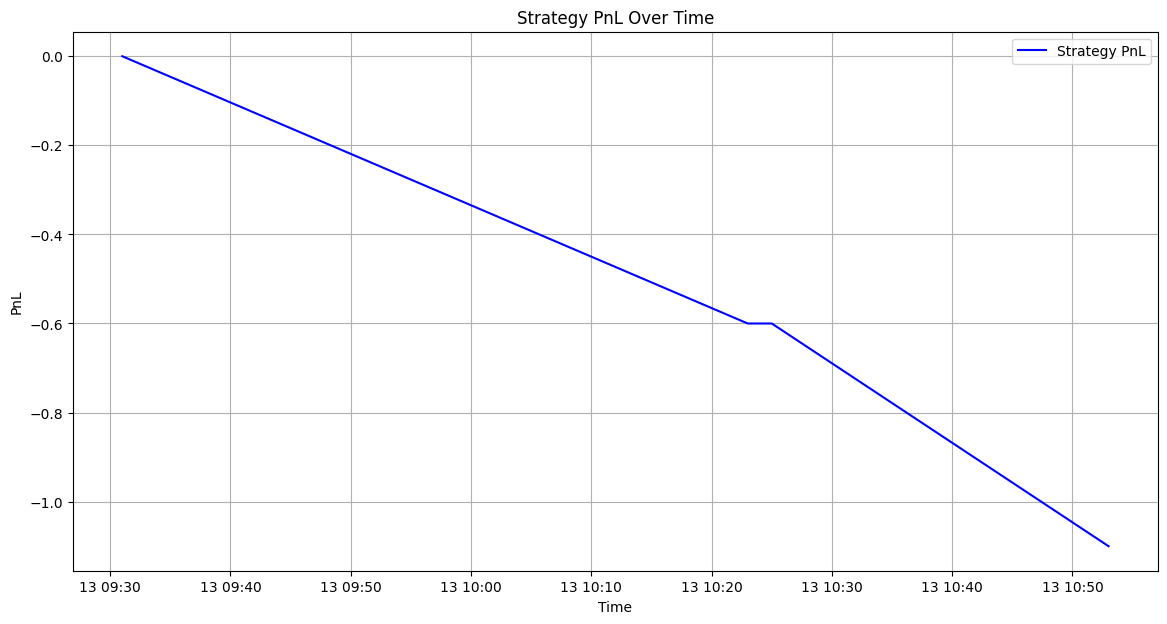

Nifty 10 minute candle: {'date': datetime.datetime(2025, 5, 14, 9, 15, tzinfo=tzoffset(None, 19800)), 'open': 24613.8, 'high': 24706.75, 'low': 24581.75, 'close': 24700, 'volume': 0}
Stock: ABCAPITAL, Initial OI: 91752900, Final OI: 91790300, OI Change: 0.04%
Stock: BHARTIARTL, Initial OI: 74812500, Final OI: 76185725, OI Change: 1.84%
Stock: MFSL, Initial OI: 9426400, Final OI: 10400000, OI Change: 10.33%
Stock: NATIONALUM, Initial OI: 111911250, Final OI: 112162500, OI Change: 0.22%
Stock: NYKAA, Initial OI: 50272025, Final OI: 50558700, OI Change: 0.57%
Stock: SAIL, Initial OI: 222094300, Final OI: 223344700, OI Change: 0.56%
Stock: TATASTEEL, Initial OI: 456951000, Final OI: 461708500, OI Change: 1.04%
Stock: CIPLA, Initial OI: 21666450, Final OI: 22493725, OI Change: 3.82%
Stock: HEROMOTOCO, Initial OI: 10253400, Final OI: 10557150, OI Change: 2.96%
Stock: PAYTM, Initial OI: 38759300, Final OI: 39565150, OI Change: 2.08%
Stock: TATAMOTORS, Initial OI: 146642900, Final OI: 15823565

/var/folders/cn/tfff3ckj5rgbdz6t7kthy19m0000gn/T/ipykernel_1136/2549434970.py:44: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  current_month_options = instr_tokens[


<Figure size 1400x700 with 0 Axes>

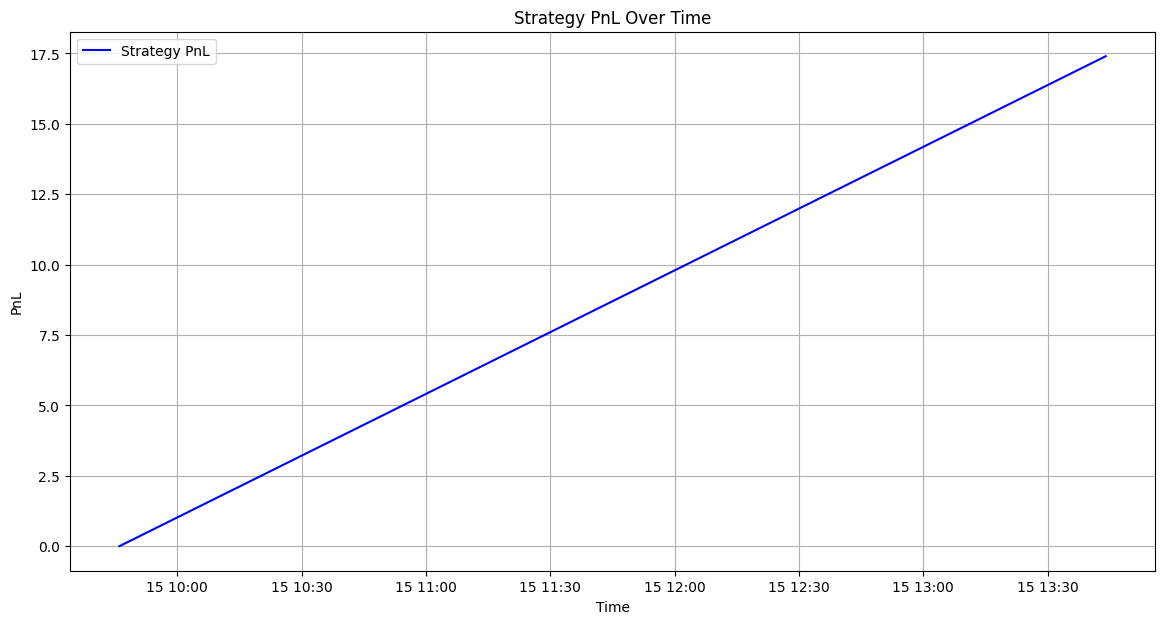

Nifty 10 minute candle: {'date': datetime.datetime(2025, 5, 16, 9, 15, tzinfo=tzoffset(None, 19800)), 'open': 25064.65, 'high': 25065.25, 'low': 24984, 'close': 25001.7, 'volume': 0}
Stock: BHARTIARTL, Initial OI: 73755625, Final OI: 82238650, OI Change: 11.50%
Stock: NCC, Initial OI: 32203825, Final OI: 32996775, OI Change: 2.46%
Final stocks to trade: [2714625]
No trading symbols provided for NFO tokens.
No trading symbols provided for NSE tokens.
No trading symbols provided for BSE tokens.
No trading symbols provided for BFO tokens.
{2714625: 'BHARTIARTL'}
Setting high_925 and low_925 for BHARTIARTL at 2025-05-16 09:26:00+05:30
Checking entry conditions for BHARTIARTL at 1819 on 2025-05-16 09:26:00+05:30
Current high_925: 1824.7
Current low_925: 1813.8
Checking entry conditions for BHARTIARTL at 1818.7 on 2025-05-16 09:27:00+05:30
Current high_925: 1824.7
Current low_925: 1813.8
Checking entry conditions for BHARTIARTL at 1817.6 on 2025-05-16 09:28:00+05:30
Current high_925: 1824.7


/var/folders/cn/tfff3ckj5rgbdz6t7kthy19m0000gn/T/ipykernel_1136/2549434970.py:44: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  current_month_options = instr_tokens[


{2714625: [{'date': datetime.datetime(2025, 5, 16, 9, 15, tzinfo=tzoffset(None, 19800)), 'open': 10.8, 'high': 10.8, 'low': 6, 'close': 9.8, 'volume': 45600}, {'date': datetime.datetime(2025, 5, 16, 9, 16, tzinfo=tzoffset(None, 19800)), 'open': 9.8, 'high': 9.8, 'low': 8.35, 'close': 8.95, 'volume': 70775}, {'date': datetime.datetime(2025, 5, 16, 9, 17, tzinfo=tzoffset(None, 19800)), 'open': 8.8, 'high': 9.25, 'low': 8.55, 'close': 9.25, 'volume': 119225}, {'date': datetime.datetime(2025, 5, 16, 9, 18, tzinfo=tzoffset(None, 19800)), 'open': 9.2, 'high': 9.65, 'low': 9, 'close': 9.2, 'volume': 83600}, {'date': datetime.datetime(2025, 5, 16, 9, 19, tzinfo=tzoffset(None, 19800)), 'open': 9.2, 'high': 9.65, 'low': 9.05, 'close': 9.2, 'volume': 119225}, {'date': datetime.datetime(2025, 5, 16, 9, 20, tzinfo=tzoffset(None, 19800)), 'open': 9.25, 'high': 9.75, 'low': 9.15, 'close': 9.55, 'volume': 138225}, {'date': datetime.datetime(2025, 5, 16, 9, 21, tzinfo=tzoffset(None, 19800)), 'open': 9.

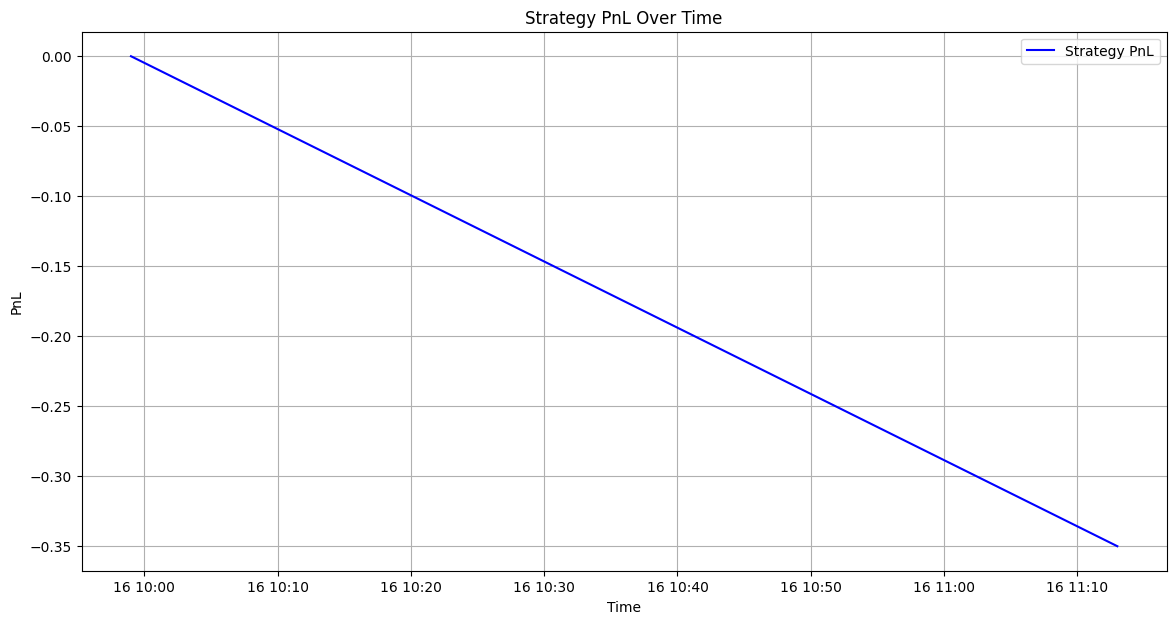

Nifty 10 minute candle: {'date': datetime.datetime(2025, 5, 19, 9, 15, tzinfo=tzoffset(None, 19800)), 'open': 25005.35, 'high': 25058.7, 'low': 24965.8, 'close': 25044.85, 'volume': 0}
Stock: AARTIIND, Initial OI: 30829250, Final OI: 30816225, OI Change: -0.04%
Stock: BEL, Initial OI: 257266650, Final OI: 270675900, OI Change: 5.21%
Stock: CDSL, Initial OI: 28078650, Final OI: 29414625, OI Change: 4.76%
Stock: CESC, Initial OI: 50143550, Final OI: 48975775, OI Change: -2.33%
Stock: CROMPTON, Initial OI: 55530000, Final OI: 55242000, OI Change: -0.52%
Stock: DELHIVERY, Initial OI: 27519325, Final OI: 31032925, OI Change: 12.77%
Stock: DIVISLAB, Initial OI: 6407700, Final OI: 7158000, OI Change: 11.71%
Stock: INOXWIND, Initial OI: 34504275, Final OI: 33752850, OI Change: -2.18%
Stock: NBCC, Initial OI: 73162600, Final OI: 71358800, OI Change: -2.47%
Stock: NCC, Initial OI: 34453950, Final OI: 33928475, OI Change: -1.53%
Stock: TIINDIA, Initial OI: 3341900, Final OI: 3346100, OI Change: 0

/var/folders/cn/tfff3ckj5rgbdz6t7kthy19m0000gn/T/ipykernel_1136/2549434970.py:44: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  current_month_options = instr_tokens[


Available expiries for DIVISLAB: [datetime.date(2025, 5, 29), datetime.date(2025, 6, 26), datetime.date(2025, 7, 31)]
[{'date': datetime.datetime(2025, 5, 19, 9, 15, tzinfo=tzoffset(None, 19800)), 'open': 85, 'high': 112.1, 'low': 85, 'close': 105, 'volume': 3100}, {'date': datetime.datetime(2025, 5, 19, 9, 16, tzinfo=tzoffset(None, 19800)), 'open': 102.1, 'high': 103.75, 'low': 82, 'close': 84.9, 'volume': 19300}, {'date': datetime.datetime(2025, 5, 19, 9, 17, tzinfo=tzoffset(None, 19800)), 'open': 84.3, 'high': 95.4, 'low': 84.3, 'close': 91.15, 'volume': 6000}, {'date': datetime.datetime(2025, 5, 19, 9, 18, tzinfo=tzoffset(None, 19800)), 'open': 91.15, 'high': 94.05, 'low': 88.6, 'close': 91.45, 'volume': 7400}, {'date': datetime.datetime(2025, 5, 19, 9, 19, tzinfo=tzoffset(None, 19800)), 'open': 91.45, 'high': 94.4, 'low': 89.95, 'close': 90.25, 'volume': 5800}, {'date': datetime.datetime(2025, 5, 19, 9, 20, tzinfo=tzoffset(None, 19800)), 'open': 90, 'high': 92.05, 'low': 88, 'clos

/var/folders/cn/tfff3ckj5rgbdz6t7kthy19m0000gn/T/ipykernel_1136/2549434970.py:44: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  current_month_options = instr_tokens[


Available expiries for DELHIVERY: [datetime.date(2025, 5, 29), datetime.date(2025, 6, 26), datetime.date(2025, 7, 31)]
[{'date': datetime.datetime(2025, 5, 19, 9, 15, tzinfo=tzoffset(None, 19800)), 'open': 1.95, 'high': 4.3, 'low': 1.85, 'close': 4.05, 'volume': 86925}, {'date': datetime.datetime(2025, 5, 19, 9, 16, tzinfo=tzoffset(None, 19800)), 'open': 4, 'high': 4.55, 'low': 3.7, 'close': 3.95, 'volume': 545950}, {'date': datetime.datetime(2025, 5, 19, 9, 17, tzinfo=tzoffset(None, 19800)), 'open': 3.8, 'high': 4.15, 'low': 3.4, 'close': 4.1, 'volume': 195200}, {'date': datetime.datetime(2025, 5, 19, 9, 18, tzinfo=tzoffset(None, 19800)), 'open': 4.1, 'high': 4.8, 'low': 3.9, 'close': 4.75, 'volume': 266875}, {'date': datetime.datetime(2025, 5, 19, 9, 19, tzinfo=tzoffset(None, 19800)), 'open': 4.7, 'high': 5.9, 'low': 4.45, 'close': 5.6, 'volume': 399550}, {'date': datetime.datetime(2025, 5, 19, 9, 20, tzinfo=tzoffset(None, 19800)), 'open': 5.6, 'high': 6.2, 'low': 5.15, 'close': 5.15

/var/folders/cn/tfff3ckj5rgbdz6t7kthy19m0000gn/T/ipykernel_1136/2549434970.py:44: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  current_month_options = instr_tokens[
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


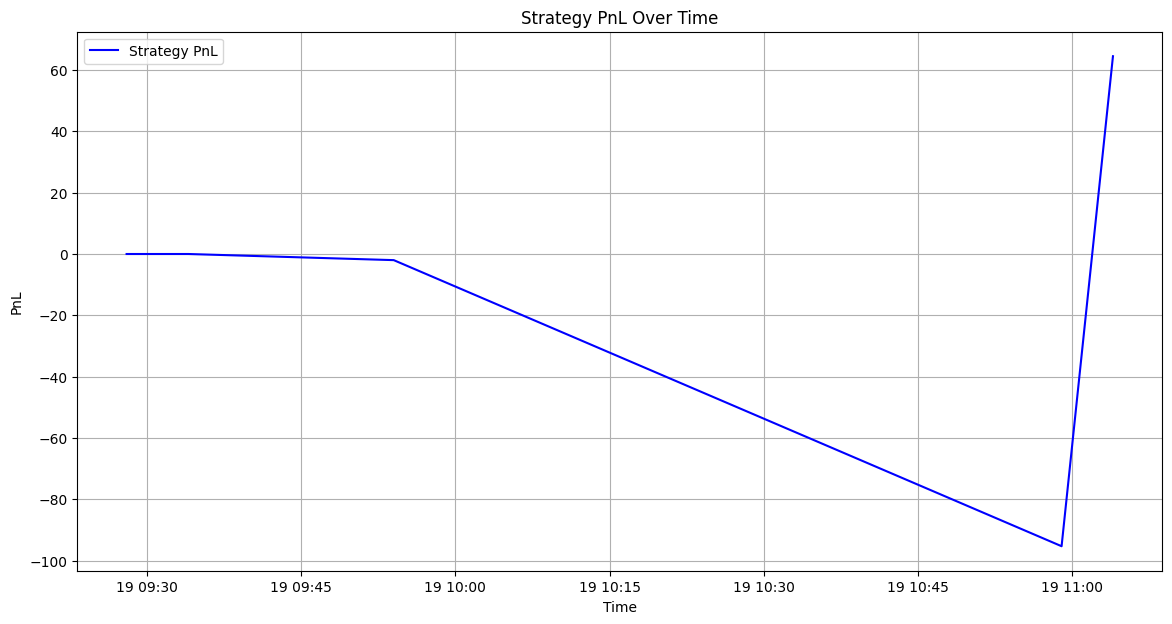

Nifty 10 minute candle: {'date': datetime.datetime(2025, 5, 20, 9, 15, tzinfo=tzoffset(None, 19800)), 'open': 24996.2, 'high': 25010.35, 'low': 24936, 'close': 24960, 'volume': 0}
Stock: HAL, Initial OI: 24112500, Final OI: 24556200, OI Change: 1.84%
Stock: IRFC, Initial OI: 196347550, Final OI: 196009350, OI Change: -0.17%
Stock: MAXHEALTH, Initial OI: 15948975, Final OI: 16213050, OI Change: 1.66%
Stock: NBCC, Initial OI: 78752900, Final OI: 75968900, OI Change: -3.54%
Stock: PHOENIXLTD, Initial OI: 4498900, Final OI: 4441850, OI Change: -1.27%
Stock: TITAGARH, Initial OI: 14005300, Final OI: 13020200, OI Change: -7.03%
Final stocks to trade: []
No trading symbols provided for NFO tokens.
No trading symbols provided for NSE tokens.
No trading symbols provided for BSE tokens.
No trading symbols provided for BFO tokens.
{}
'realized_pnl'
Nifty 10 minute candle: {'date': datetime.datetime(2025, 5, 21, 9, 15, tzinfo=tzoffset(None, 19800)), 'open': 24744.25, 'high': 24766.15, 'low': 24700

/var/folders/cn/tfff3ckj5rgbdz6t7kthy19m0000gn/T/ipykernel_1136/2549434970.py:44: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  current_month_options = instr_tokens[


Nifty 10 minute candle: {'date': datetime.datetime(2025, 5, 23, 9, 15, tzinfo=tzoffset(None, 19800)), 'open': 24639.5, 'high': 24720.9, 'low': 24614.05, 'close': 24719.2, 'volume': 0}
Stock: GRASIM, Initial OI: 14489750, Final OI: 14850750, OI Change: 2.49%
Stock: VBL, Initial OI: 75907475, Final OI: 76379300, OI Change: 0.62%
Stock: CONCOR, Initial OI: 39830000, Final OI: 41587000, OI Change: 4.41%
Stock: GMRAIRPORT, Initial OI: 299392425, Final OI: 296842725, OI Change: -0.85%
Stock: RAMCOCEM, Initial OI: 9894000, Final OI: 10430350, OI Change: 5.42%
Stock: SUNPHARMA, Initial OI: 37648450, Final OI: 40928300, OI Change: 8.71%
Final stocks to trade: [523009, 857857]
No trading symbols provided for NFO tokens.
No trading symbols provided for NSE tokens.
No trading symbols provided for BSE tokens.
No trading symbols provided for BFO tokens.
{523009: 'RAMCOCEM', 857857: 'SUNPHARMA'}
Setting high_925 and low_925 for RAMCOCEM at 2025-05-23 09:26:00+05:30
Checking entry conditions for RAMCO

/var/folders/cn/tfff3ckj5rgbdz6t7kthy19m0000gn/T/ipykernel_1136/2549434970.py:44: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  current_month_options = instr_tokens[


<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

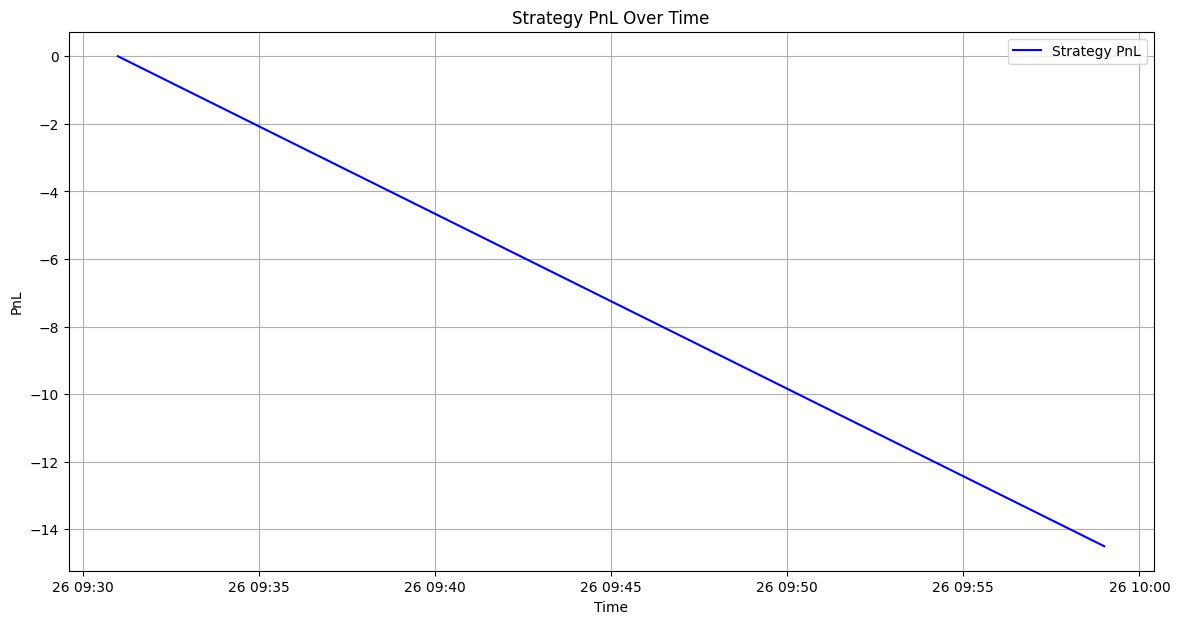

Nifty 10 minute candle: {'date': datetime.datetime(2025, 5, 27, 9, 15, tzinfo=tzoffset(None, 19800)), 'open': 24956.65, 'high': 24976.1, 'low': 24769.3, 'close': 24790.65, 'volume': 0}
Stock: INDIGO, Initial OI: 14787150, Final OI: 17404500, OI Change: 17.70%
Final stocks to trade: [2865921]
No trading symbols provided for NFO tokens.
No trading symbols provided for NSE tokens.
No trading symbols provided for BSE tokens.
No trading symbols provided for BFO tokens.
{2865921: 'INDIGO'}
Setting high_925 and low_925 for INDIGO at 2025-05-27 09:26:00+05:30
Checking entry conditions for INDIGO at 5284.5 on 2025-05-27 09:26:00+05:30
Current high_925: 5303.5
Current low_925: 5264.5
Checking entry conditions for INDIGO at 5286.5 on 2025-05-27 09:27:00+05:30
Current high_925: 5303.5
Current low_925: 5264.5
Checking entry conditions for INDIGO at 5300 on 2025-05-27 09:28:00+05:30
Current high_925: 5303.5
Current low_925: 5264.5
Checking entry conditions for INDIGO at 5300 on 2025-05-27 09:29:00+0

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

In [8]:
strt_date = "2025-05-13"
en_date = "2025-05-28"

start = datetime.strptime(strt_date, "%Y-%m-%d")
end = datetime.strptime(en_date, "%Y-%m-%d")

# Generate list of date strings
all_dates = [(start + timedelta(days=i)).strftime("%Y-%m-%d") for i in range((end - start).days + 1)]

print(all_dates)

for date in all_dates:
    start_date = date
    top_gainers = []
    top_losers = []
    for stocks in instrument_tokens:
        data=kite.historical_data(stocks, date, date, "5minute")
        if data is None or len(data) == 0:
            # print(f"No data available for {stocks} on {date}. Skipping...")
            continue
        def get_previous_trading_day(date_str):
            date = datetime.strptime(date_str, "%Y-%m-%d")
            prev_day = date - timedelta(days=1)
            # Skip weekends (Saturday=5, Sunday=6)
            while prev_day.weekday() >= 5:
                prev_day -= timedelta(days=1)
            return prev_day.strftime("%Y-%m-%d")

        previous_trading_day = get_previous_trading_day(date)
        data2 = kite.historical_data(stocks, previous_trading_day, previous_trading_day, "day")
        while data2 is None or len(data2) == 0:
            previous_trading_day = get_previous_trading_day(previous_trading_day)
            data2 = kite.historical_data(stocks, previous_trading_day, previous_trading_day, "day")
        candle = data[0]
        candle2 = data2[0]
        change= (candle['close'] - candle2['close']) / candle2['close'] * 100
        if change > 2:
            top_gainers.append(stocks)
        elif change < -2:
            top_losers.append(stocks)

    nifty10_candle = kite.historical_data(256265, date, date, "10minute")
    if nifty10_candle is None or len(nifty10_candle) == 0:
        # print(f"No 10 minute candle data available for Nifty on {date}. Skipping...")
        continue
    print(f"Nifty 10 minute candle: {nifty10_candle[0]}")
    if nifty10_candle[0]['open']>nifty10_candle[0]['close']:
        top_gainers=[]
        
    stocks_to_trade = top_gainers + top_losers


        
    final_stocks = []

    for stock in stocks_to_trade:
        symbol = instruments_NSE[instruments_NSE['instrument_token'] == stock]['tradingsymbol'].values[0]
        option_token = get_all_derivative_token(symbol)
        initial_oi = 0
        final_oi = 0
        for token in option_token:
            oi_data = kite.historical_data(token, date, date, "10minute",oi=True)
            oi_data2 = kite.historical_data(token, previous_trading_day, previous_trading_day, "day",oi=True)
            initial_oi += oi_data2[0]['oi'] if oi_data2 else 0
            try:
                final_oi += oi_data[0]['oi']
            except IndexError:
                # print(f"OI data for {token}{symbol} not available for the specified date range.")
                continue
            # if oi_data:
            #     initial_oi += oi_data[0]['oi']
            #     final_oi += oi_data[5]['oi']
        oi_change = (final_oi - initial_oi) / initial_oi * 100 if initial_oi != 0 else 0
        if oi_change > 5:
            final_stocks.append(stock)
        print(f"Stock: {symbol}, Initial OI: {initial_oi}, Final OI: {final_oi}, OI Change: {oi_change:.2f}%")


    print(f"Final stocks to trade: {final_stocks}")
    strategy_name = "SSO_5oi_" + date
    config = {
        "strategy_name": strategy_name,

        "start_date": date,
        "end_date": date,
        "interval": "minute",
        'tokens':final_stocks,

        "top_gainers": top_gainers,
        "top_losers": top_losers,
    }

    backtest = SSO_strategy(config)
    try:
        backtest.run()
        backtest.plot_results()
    except Exception as e:
        print(e)
        continue

{'PNBHOUSING': np.float64(-6012.5)}
Date: 2025-05-02, PNL: -6012.5, Margin: 16737.5
No trades found for 2025-05-05
{'INDHOTEL': np.float64(-850.0000000000018)}
Date: 2025-05-06, PNL: -850.0000000000018, Margin: 16350.000000000002
No trades found for 2025-05-07
No trades found for 2025-05-08
No trades found for 2025-05-09
{'UPL': np.float64(-1490.5)}
Date: 2025-05-13, PNL: -1490.5, Margin: 13685.5
No trades found for 2025-05-14
{'MUTHOOTFIN': np.float64(4785.0)}
Date: 2025-05-15, PNL: 4785.0, Margin: 11687.5
{'BHARTIARTL': np.float64(-166.25)}
Date: 2025-05-16, PNL: -166.25, Margin: 5082.5
{'BEL': np.float64(-5700.0), 'DIVISLAB': np.float64(6160.0), 'DELHIVERY': np.float64(7472.5)}
Date: 2025-05-19, PNL: 7932.5, Margin: 40638.75
No trades found for 2025-05-20
No trades found for 2025-05-21
No trades found for 2025-05-22
No trades found for 2025-05-23
{'BALKRISIND': np.float64(-4350.0)}
Date: 2025-05-26, PNL: -4350.0, Margin: 9300.0
No trades found for 2025-05-27
No trades found for 2025

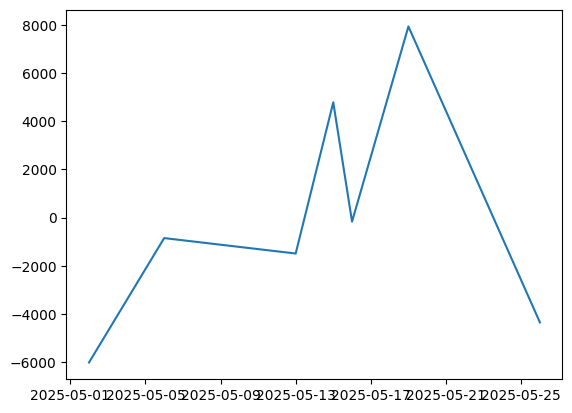

In [14]:
from datetime import datetime, timedelta
import os
import pandas as pd
from matplotlib import pyplot as plt
path = '/Users/sushrutkagde/Documents/Project_X/backtesting_framework/single_stock_option_strategy/'
strt_date = "2025-05-02"
en_date = "2025-05-28"

start = datetime.strptime(strt_date, "%Y-%m-%d")
end = datetime.strptime(en_date, "%Y-%m-%d")
kite = KiteConnect(os.getenv("api_key"), os.getenv("access_token"))
# Generate list of date strings
all_dates = [(start + timedelta(days=i)).strftime("%Y-%m-%d") for i in range((end - start).days + 1)]

def get_lot_size(symbol):
    instruments = pd.DataFrame(kite.instruments("NFO"))
    lot_size = instruments.loc[instruments['name'] == symbol,'lot_size'].values[0]
    return lot_size

overall_pnl = 0
required_capital = 0
pnl_array = []
for date in all_dates:
    file_name = os.path.join(path, f"SSO_5oi_{date}",'trades.csv')
    if os.path.exists(file_name):
        trades_df = pd.read_csv(file_name)
    else:
        continue
    if trades_df.empty:
        print(f"No trades found for {date}")
        continue
    orders = {}
    capital = {}
    for index, row in trades_df.iterrows():
        if row['tradingsymbol'] not in orders:
            orders[row['tradingsymbol']] = 0
            capital[row['tradingsymbol']] = None

        lot = get_lot_size(row['tradingsymbol'])
        if row['type'] == 'BUY':
            if capital[row['tradingsymbol']] is None:
                capital[row['tradingsymbol']] = row['order_price']*lot
            orders[row['tradingsymbol']] += row['pnl']*lot
        else:
            orders[row['tradingsymbol']] += row['pnl']*lot
        # pnl += row['pnl']
    day_pnl = sum(orders.values())
    invested_capital = sum(capital.values())
    print(orders)

    print(f"Date: {date}, PNL: {day_pnl}, Margin: {invested_capital}")
    overall_pnl+=day_pnl
    required_capital+=invested_capital
    pnl_array.append((date,day_pnl))
print(f"Overall PNL: {overall_pnl}, Margin: {required_capital}")

x,y = zip(*pnl_array)
plt.plot(pd.to_datetime(x),y)
plt.show()